In [1]:
from autograd import *
from matplotlib import pyplot as plt
from sklearn.datasets import load_iris
import tensorflow as tf
import torch
import numpy as np
%matplotlib inline

In [2]:
features, target = load_iris().data, load_iris().target
target = (target >= 1).astype("i")
features = features[:, :2]

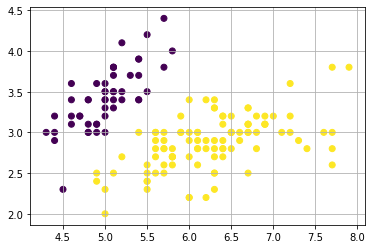

In [3]:
plt.scatter(features[:, 0], features[:, 1], c=target)
plt.grid()

Simple Logistic
===

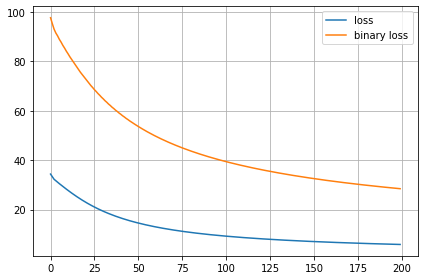

In [4]:
np.random.seed(0)

sigmoid = lambda x: 1 / (1 + np.exp(-x))
sigmoid_prod = lambda x: sigmoid(x) * (1 - sigmoid(x))
binary_loss = lambda t, p: sum(-t * np.log(p) - (1 - t) * np.log(1 - p))[0]

target = target.reshape((-1, 1))
W = np.random.laplace(0, 0.2, size=(2, 1))

loss_story = []
binary_loss_story = []

for i in range(200):
    layer = features @ W                    # (150, 1)                          C
    predict = sigmoid(layer)                # (150, 1)                          B
    loss = sum((target - predict) ** 2)     #                                   A
    loss_story.append(loss)
    
    binary_loss_story.append(binary_loss(target, predict))

    delta = (predict - target) * 2          # (150, 1)                          A`
    one_step = delta * sigmoid_prod(layer)  # (150, 1)                          A` * B`
    two_step = features.T @ one_step        # (150, 2).T @ (150, 1) = (2, 1)    C` @ (A` * B`)
    W -= two_step * 0.0025
    
plt.plot(loss_story, label="loss")
plt.plot(binary_loss_story, label="binary loss")
plt.legend()
plt.tight_layout()
plt.grid()

In [5]:
sum((sigmoid(features @ W) > 0.5).astype("i") == target) / 150

array([0.99333333])

autograd  binary
===

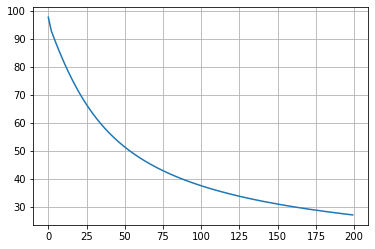

In [6]:
np.random.seed(0)

target = target.reshape((-1, 1))
W = np.random.laplace(0, 0.2, size=(2, 1))

W = TensorData(W)
X = TensorData(features)

r = X.dot(W).sigmoid().binary_cross_entropy(target)
loss_story = []
for i in range(200):
    loss_story.append(r.forward())
    r.bprop()
    W.data -= W.gradient * 0.005
    W.gradient *= 0.1
    
plt.plot(loss_story)
plt.grid()

In [7]:
b = X.dot(W).sigmoid()
sum((b.forward() > 0.5).astype("i") == target) / 150

array([0.99333333])

autograd crossentropy
===

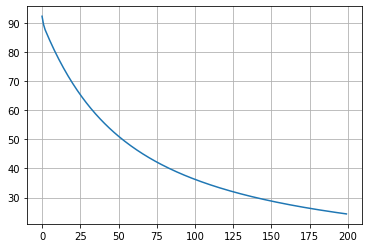

In [8]:
np.random.seed(0)
target = target.flatten()
W = np.random.laplace(0, 0.2, size=(2, 2))

W = TensorData(W)
X = TensorData(features)

loss_story = []

for i in range(200):
    r = X.dot(W).cross_entropy(target)
    loss_story.append(r.forward())

    r.bprop()
    W.data -= W.gradient * 0.0005
    W.gradient *= 0.1
    
plt.plot(loss_story)
plt.grid()

In [9]:
r = X.dot(W)
sum(r.forward().argmax(1) == target) / 150

0.9933333333333333

Tensorflow
===

In [4]:
learning_rate = 0.001
n_steps = 10 ** 4
story_loss = []

with tf.name_scope('placeholder'):
    x = tf.placeholder(tf.float32, (None, 2))
    y = tf.placeholder(tf.float32,(None, ))
with tf.name_scope('weghts'):
    W = tf.Variable(tf.random_normal((2, 1)))
    b = tf.Variable(tf.random_normal((1, )))
with tf.name_scope('prediction'):
    y_logit = tf.squeeze(tf.matmul(x, W) + b)
#     y_one_prob = tf.sigmoid(y_logit)
#     y_pred = tf.round(y_one_prob)
with tf.name_scope('loss'):
    entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=y_logit, labels=y)# BCE
    l = tf.reduce_sum(entropy)
with tf.name_scope('optimizer'):
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(l)
# with tf.name_scope('summaries'):
#     tf.summary.scalar('loss', l)
#     merged = tf.summary.merge_all()

# train_writrer = tf.summary.FileWriter('./tmp/logistic-train', tf.get_default_graph())

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


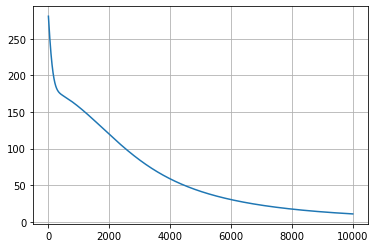

In [5]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_steps):
        feed_dict = {x:features, y:target}
        _, loss = sess.run([train_op, l], feed_dict=feed_dict)
#         print(f"step {i}  loss is {loss}")
#         train_writrer.add_summary(summary, i)
        story_loss.append(loss)
    w_value = sess.run(W)
    b_value = sess.run(b)
plt.plot(story_loss)
plt.grid()

In [6]:
sigmoid = lambda x: 1 / (1 + np.exp(- x))
predict = sigmoid(features @ w_value + b_value) > 0.5
(np.squeeze(predict) == target).sum() / predict.shape[0]

0.9933333333333333

Native BinaryCrossEntropy
===

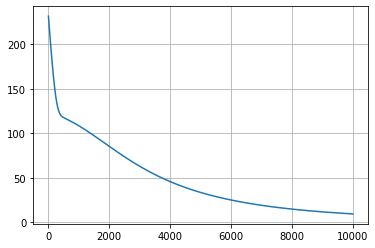

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.datasets import load_iris
%matplotlib inline

features, target = load_iris().data, load_iris().target
target = (target >= 1).astype("i")
features = features[:, :2]

learning_rate = 0.001
n_steps = 10 ** 4
story_loss = []

with tf.name_scope('placeholder'):
    x = tf.placeholder(tf.float32, (None, 2))
    y = tf.placeholder(tf.float32,(None, ))
with tf.name_scope('weghts'):
    W = tf.Variable(tf.random_normal((2, 1)))
    b = tf.Variable(tf.random_normal((1, )))
with tf.name_scope('prediction'):
    y_logit = tf.squeeze(tf.sigmoid(tf.matmul(x, W) + b))
with tf.name_scope('loss'):
    l = tf.reduce_sum(-y * tf.log(y_logit) - (1 - y) * tf.log(1 - y_logit))
with tf.name_scope('optimizer'):
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(l)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_steps):
        feed_dict = {x:features, y:target}
        _, loss = sess.run([train_op, l], feed_dict=feed_dict)
        story_loss.append(loss)
    w_value = sess.run(W)
    b_value = sess.run(b)
plt.plot(story_loss)
plt.grid()

In [7]:
tf.nn.softmax_cross_entropy_with_logits
tf.nn.softmax

<function tensorflow.python.ops.nn_ops.softmax(logits, axis=None, name=None, dim=None)>

In [9]:
tf.losses.mean_squared_error
tf.losses.sigmoid_cross_entropy
tf.losses.softmax_cross_entropy

<function tensorflow.python.ops.losses.losses_impl.softmax_cross_entropy(onehot_labels, logits, weights=1.0, label_smoothing=0, scope=None, loss_collection='losses', reduction='weighted_sum_by_nonzero_weights')>

In [14]:
tf.keras.losses.BinaryCrossentropy
tf.keras.losses.CategoricalCrossentropy
tf.keras.losses.kullback_leibler_divergence
tf.keras.losses.CategoricalHinge
tf.keras.losses.CosineSimilarity
tf.keras.losses.MAE
tf.keras.losses.MAPE
tf.keras.losses.MSE
tf.keras.losses.MSLE
tf.keras.losses.MeanSquaredError
tf.keras.losses.MeanAbsoluteError
tf.keras.losses.MeanAbsolutePercentageError
tf.keras.losses.MeanSquaredLogarithmicError
tf.keras.losses.SparseCategoricalCrossentropy

tensorflow.python.keras.losses.SparseCategoricalCrossentropy

softmax
===

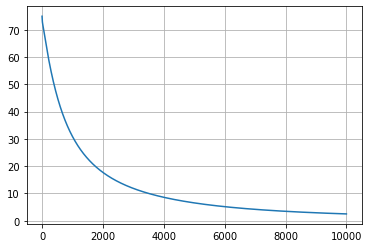

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.datasets import load_iris
import numpy as np
%matplotlib inline

features, target = load_iris().data, load_iris().target
target = (target >= 1).astype("i")
target = np.eye(2, dtype="i")[target]
features = features[:, :2]

learning_rate = 0.001
n_steps = 10 ** 4
story_loss = []

with tf.name_scope('placeholder'):
    x = tf.placeholder(tf.float32, (None, 2))
    y = tf.placeholder(tf.float32,(None, 2))
with tf.name_scope('weghts'):
    W = tf.Variable(tf.random_normal((2, 2)))
    b = tf.Variable(tf.random_normal((2, )))
with tf.name_scope('prediction'):
    y_logit = tf.squeeze(tf.matmul(x, W) + b)
with tf.name_scope('loss'):
    l = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_logit, labels=y))
with tf.name_scope('optimizer'):
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(l)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_steps):
        feed_dict = {x:features, y:target}
        _, loss = sess.run([train_op, l], feed_dict=feed_dict)
        story_loss.append(loss)
    w_value = sess.run(W)
    b_value = sess.run(b)
plt.plot(story_loss)
plt.grid()

---

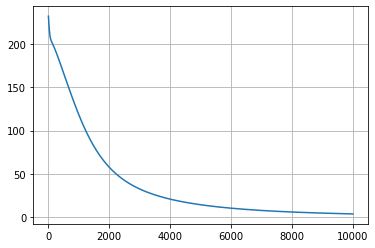

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.datasets import load_iris
import numpy as np
%matplotlib inline

features, target = load_iris().data, load_iris().target
target = (target >= 1).astype("i")
target = np.eye(2, dtype="i")[target]
features = features[:, :2]

learning_rate = 0.001
n_steps = 10 ** 4
story_loss = []

with tf.name_scope('placeholder'):
    x = tf.placeholder(tf.float32, (None, 2))
    y = tf.placeholder(tf.float32,(None, 2))
with tf.name_scope('weghts'):
    W = tf.Variable(tf.random_normal((2, 2)))
    b = tf.Variable(tf.random_normal((2, )))
with tf.name_scope('prediction'):
    y_logit = tf.squeeze(tf.matmul(x, W) + b)
with tf.name_scope('loss'):
#     l = tf.reduce_sum(-y * tf.math.log(tf.nn.softmax(y_logit)))
    l = tf.reduce_sum(-y * tf.nn.log_softmax(y_logit))
with tf.name_scope('optimizer'):
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(l)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_steps):
        feed_dict = {x:features, y:target}
        _, loss = sess.run([train_op, l], feed_dict=feed_dict)
        story_loss.append(loss)
    w_value = sess.run(W)
    b_value = sess.run(b)
plt.plot(story_loss)
plt.grid()

Torch
===

Simple native binary crossentropy
===

0.9933333333333333


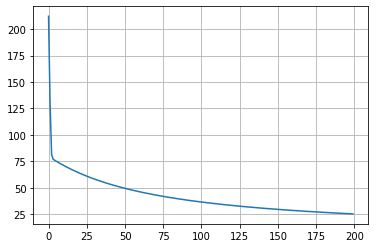

In [9]:
data = torch.Tensor(features)
label = torch.Tensor(target)
W = torch.rand(2, 1, requires_grad=True)
story_loss = []

for i in range(200):
    out = torch.sigmoid(data @ W).squeeze()
    error = sum(-(label * torch.log(out) + (1 - label) * (torch.log(1 - out))))
    story_loss.append(error.data)
    error.backward()
    W.data -= W.grad * 0.001
    W.grad *= 0.001
    
plt.plot(story_loss)
error = ((torch.sigmoid(data @ W) > 0.5).squeeze() == label).sum().tolist() / label.size(0)
print(error)
plt.grid()

use torch BinaryCrossEntropy
===

In [40]:
data = torch.Tensor(features)
label = torch.Tensor(target)
W = torch.rand(2, 1, requires_grad=True)
loss_story = []
loss_func = torch.nn.BCELoss()
optimizer = torch.optim.Adam([W], lr=0.01)

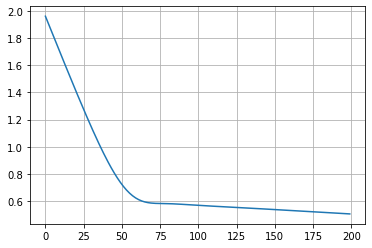

In [41]:
for i in range(200):
    optimizer.zero_grad()
    predict = torch.sigmoid(data @ W).squeeze()
    loss = loss_func(predict, label)
    loss_story.append(loss.item())
    loss.backward()
    optimizer.step()
    
plt.plot(loss_story)
plt.grid()

use Torch BinaryCrossEntropyWithLogistic
===

In [43]:
data = torch.Tensor(features)
label = torch.Tensor(target)
W = torch.rand(2, 1, requires_grad=True)
loss_story = []
loss_func = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam([W], lr=0.01)

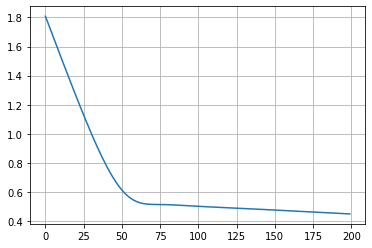

In [44]:
for i in range(200):
    optimizer.zero_grad()
    predict = (data @ W).squeeze()
    loss = loss_func(predict, label)
    loss_story.append(loss.item())
    loss.backward()
    optimizer.step()
    
plt.plot(loss_story)
plt.grid()

use CrossEntropy
===

In [12]:
label = torch.tensor(target, dtype=torch.int64)
data = torch.Tensor(features)
W = torch.rand(2, 2, requires_grad=True)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([W], lr=0.02)
loss_story = []

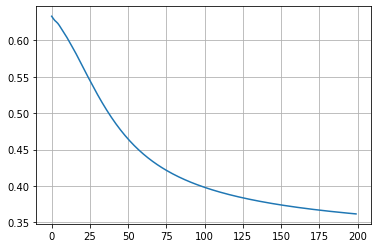

In [13]:
for i in range(200):
    optimizer.zero_grad()
    predict = torch.softmax(data @ W, 1)
    loss = loss_func(predict, label)
    loss_story.append(loss.item())
    loss.backward()
    optimizer.step()

plt.plot(loss_story)
plt.grid()

In [35]:
((data @ W).data.numpy().argmax(1) == target).sum() / target.shape[0]

0.9933333333333333

Simple Native CrossEntropy
===

In [86]:
label = torch.tensor(np.eye(2)[target]).long()
data = torch.Tensor(features)
W = torch.rand(2, 2, requires_grad=True)

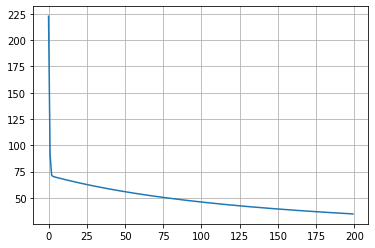

In [87]:
loss_story = []
for i in range(200):
    predict = torch.softmax(data @ W, 1)
    loss = (-label * torch.log(predict)).sum()
    loss_story.append(loss.item())
    loss.backward()
    W.data -= W.grad * 0.00025
    W.grad *= 0.01
plt.plot(loss_story)
plt.grid()